In [1]:
import sys
sys.path.append('../')

import torch 
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations


from compute_ntk import get_ntk, get_fnet_single
from boston.dataset import BostonDataset

DEVICE="cuda"

In [2]:
dataset = BostonDataset(path="../boston/Boston.csv")

x_ntk = torch.stack([dataset[i][0] for i in range(100)]).to(DEVICE)

In [3]:
class Network(nn.Module):
    def __init__(self, hidden_dim):
        super(Network, self).__init__()

        self.block = nn.Sequential(
            nn.Linear(13, hidden_dim, bias=False),
            nn.Tanh(),
            nn.Linear(hidden_dim, 1, bias=False)
        )
        self.init_weights()
    def forward(self, x):
        return self.block(x)
    
    def init_weights(self):
        for i, m in enumerate(self.block):
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0.0, std=1.0/np.sqrt(m.in_features))


/home/svilhes/anaconda3/envs/anots/lib/python3.11/site-packages/torch/autograd/graph.py:841: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Dim 50: mean pairwise NTK distance = 1622.3341
Dim 100: mean pairwise NTK distance = 2493.4861
Dim 500: mean pairwise NTK distance = 12648.7871
Dim 1000: mean pairwise NTK distance = 26439.6543
Dim 5000: mean pairwise NTK distance = 144793.4219
Dim 10000: mean pairwise NTK distance = 281470.1875
Dim 50000: mean pairwise NTK distance = 1462737.8750
Dim 100000: mean pairwise NTK distance = 3008782.0000


/tmp/ipykernel_18143/2751256454.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=dims, showmeans=True, patch_artist=True)


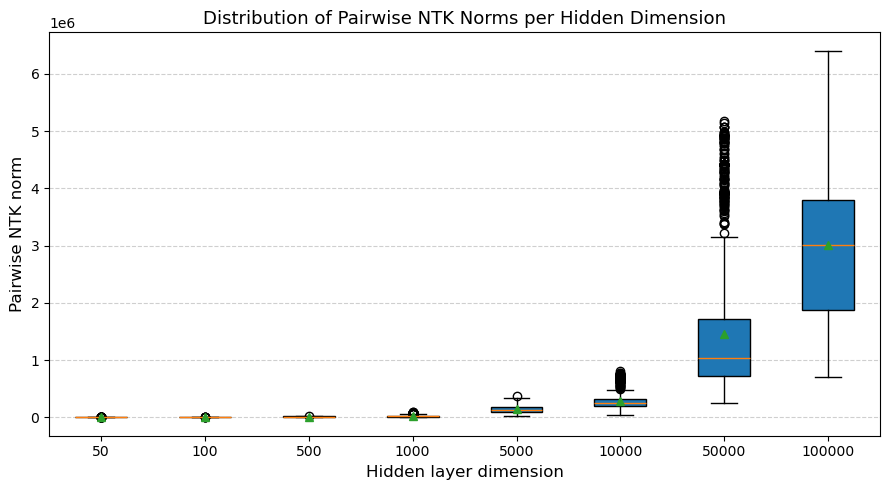

In [4]:
ITER = 50

results_dict = {
    50: [[] for _ in range(ITER)],
    100: [[] for _ in range(ITER)],
    500: [[] for _ in range(ITER)],
    1_000: [[] for _ in range(ITER)],
    5_000: [[] for _ in range(ITER)],
    10_000: [[] for _ in range(ITER)],
    50_000: [[] for _ in range(ITER)],
    100_000: [[] for _ in range(ITER)],
}

pairwise_dists = {}  # store all distances per dim

for dim in results_dict.keys():

    ntk_vectors = []

    # Compute NTK vectors for each iteration
    for iter in range(ITER):
        model = Network(dim).to(DEVICE)
        parameters = {k: v.detach() for k, v in model.named_parameters()}
        fnet_single = get_fnet_single(model)

        ntk = get_ntk(fnet_single, parameters, x_ntk, multi=False)
        n = ntk.shape[0]
        idx = torch.triu_indices(n, n)
        ntk_flat = ntk[idx[0], idx[1]].cpu().numpy()

        ntk_vectors.append(ntk_flat)
        results_dict[dim][iter] = ntk_flat

    # Compute pairwise distances between all 50 flattened NTKs
    pairwise = []
    for i, j in combinations(range(ITER), 2):
        diff = ntk_vectors[i] - ntk_vectors[j]
        dist = np.linalg.norm(diff)
        pairwise.append(dist)

    pairwise_dists[dim] = np.array(pairwise)

# Print mean pairwise distance for each dimension
for dim, dists in pairwise_dists.items():
    print(f"Dim {dim}: mean pairwise NTK distance = {dists.mean():.4f}")

# ==========================
# 📊 Plot NTK pairwise distance distributions
# ==========================

dims = sorted(pairwise_dists.keys())
data = [pairwise_dists[dim] for dim in dims]

plt.figure(figsize=(9, 5))
plt.boxplot(data, labels=dims, showmeans=True, patch_artist=True)

plt.xlabel("Hidden layer dimension", fontsize=12)
plt.ylabel("Pairwise NTK norm", fontsize=12)
plt.title("Distribution of Pairwise NTK Norms per Hidden Dimension", fontsize=13)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()
plt.show()